In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
%matplotlib inline

# Processing

In [72]:
df = pd.read_csv('train.csv')
print("columns", df.columns)
print("length", len(df))
df

columns Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
length 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


891
20


0.69999999999999996

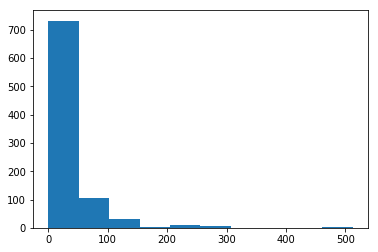

In [197]:
plt.hist(df['Fare'])
print(len(df))
print(len(df[df['Fare'] > 200]))
sum(df[df['Fare'] > 200]['Survived']) /20

In [198]:
def preprocess(df):
    # reassign id
#     df.index = df.PassengerId

    # drop not imp data
#     df.drop("PassengerId", axis=1, inplace=True)
    
    # avg_age
    avg_age = df['Age'].mean()
#     avg_age = df['Age'].median()
#     std = df['Age'].std()
#     mean = df['Age'].mean()
#     size = len(df[pd.isnull(df['Age'])])
#     age_null_random_list = np.random.randint(mean - std, mean + std, size=size)
#     df.loc[pd.isnull(df['Age']), 'Age'] = age_null_random_list
    
    # age
    def agecat(age):
        if age <= 16:
            cat = 0
        elif age > 16 and age <= 32:
            cat = 1
        elif age > 32 and age <= 48:
            cat = 2
        elif age < 48 and age <= 64:
            cat = 3
        else:
            cat = 4
        return cat
    
    # avg_fare
    fares_notnull = df[pd.notnull(df['Fare'])]['Fare']
    avg_fare = sum(fares_notnull) / len(fares_notnull)    

    # ticket
    ticket_cat = {}
    for ticket in df['Ticket']:
        if ticket.isdigit():
            ticket_cat[ticket] = 1
        elif ticket.startswith('A'):
            ticket_cat[ticket] = 2
        elif ticket.startswith('C'):
            ticket_cat[ticket] = 3
        elif ticket.startswith('F'):
            ticket_cat[ticket] = 4
        elif ticket.startswith('P'):
            ticket_cat[ticket] = 5
        elif ticket.startswith('SOTON'):
            ticket_cat[ticket] = 6
        elif ticket.startswith('STON'):
            ticket_cat[ticket] = 7
        elif ticket.startswith('S'):
            ticket_cat[ticket] = 8
        elif ticket.startswith('W'):
            ticket_cat[ticket] = 9
        else:
            ticket_cat[ticket] = 0
    
    # cabin
    cabin_cat = {}
    for cabin in df['Cabin']:
        if pd.isnull(cabin):
            cabin_cat[cabin] = 0
        elif cabin.startswith('A'):
            cabin_cat[cabin] = 1
        elif cabin.startswith('B'):
            cabin_cat[cabin] = 2
        elif cabin.startswith('C'):
            cabin_cat[cabin] = 3
        elif cabin.startswith('D'):
            cabin_cat[cabin] = 4
        elif cabin.startswith('E'):
            cabin_cat[cabin] = 5
        else:
            cabin_cat[cabin] = 0
    
    # embarked
    embarked_cat = {}
    for embarked in df['Embarked']:
        if pd.isnull(embarked):
            embarked_cat[embarked] = 0
        elif embarked.startswith('S'):
            embarked_cat[embarked] = 0
        elif embarked.startswith('Q'):
            embarked_cat[embarked] = 1
        elif embarked.startswith('C'):
            embarked_cat[embarked] = 2
            
            
    # title
    title_mapping= {
        'Ms':"Miss",
        'Mlle':"Miss",
        'Miss':"Miss",
        'Mrs':"Mrs",
        'Mme':"Mrs",
        'MrsMartin(ElizabethL':"Mrs",
        'Mr':"Mr"
        }
    
    title_cat = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    
    def applyfun(row):
        row['Has_Cabin'] = 0 if pd.isnull(row['Cabin']) else 1

        row['Age'] = row['Age'] if pd.notnull(row['Age']) else avg_age
        row['Age_Cat'] = agecat(row['Age'])
        
        row['Fare'] = row['Fare'] if pd.notnull(row['Fare']) else avg_fare
        row['Ticket'] = ticket_cat.get(row['Ticket'])
        row['Cabin'] = cabin_cat.get(row['Cabin'])
        row['Embarked'] = embarked_cat.get(row['Embarked'])
        row['Sex'] = 1 if row['Sex'] == 'male' else 0

        row['Name_Length'] = len(row['Name'])
        row['Family_Size'] = row['SibSp'] + row['Parch']
        row['Is_Alone'] = 1 if row['Family_Size'] == 1 else 0
        row['High_Price_Fare'] = 1 if row['Fare'] > 200 else 0
        
        call = re.search(r'\,.+\.', row['Name']).group(0).replace(",", "").replace(".", "").replace(" ", "")
        call_cat = title_cat.get(title_mapping.get(call, "Rare"))
        row['Title'] = call_cat
        return row
    
    df = df.apply(applyfun, axis=1)
    df.drop('Name', axis=1, inplace=True)
    return df

In [199]:
df = pd.read_csv('train.csv')
df = preprocess(df)

# Data Description

In [951]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Has_Cabin', 'Name_Length',
       'Family_Size', 'Is_Alone', 'Title'],
      dtype='object')

In [952]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Name_Length,Family_Size,Is_Alone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,2.017957,32.204208,0.648709,0.463524,0.228956,26.965208,0.904602,0.180696,1.773288
std,257.353842,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,2.059702,49.693429,1.376792,0.791503,0.420397,9.281607,1.613459,0.384982,1.143720
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,1.000000,7.910400,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,1.000000,14.454200,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,2.000000,31.000000,0.000000,1.000000,0.000000,30.000000,1.000000,0.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,9.000000,512.329200,5.000000,2.000000,1.000000,82.000000,10.000000,1.000000,5.000000


In [953]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null int64
Fare           891 non-null float64
Cabin          891 non-null int64
Embarked       891 non-null int64
Has_Cabin      891 non-null int64
Name_Length    891 non-null int64
Family_Size    891 non-null int64
Is_Alone       891 non-null int64
Title          891 non-null int64
dtypes: float64(2), int64(14)
memory usage: 111.5 KB


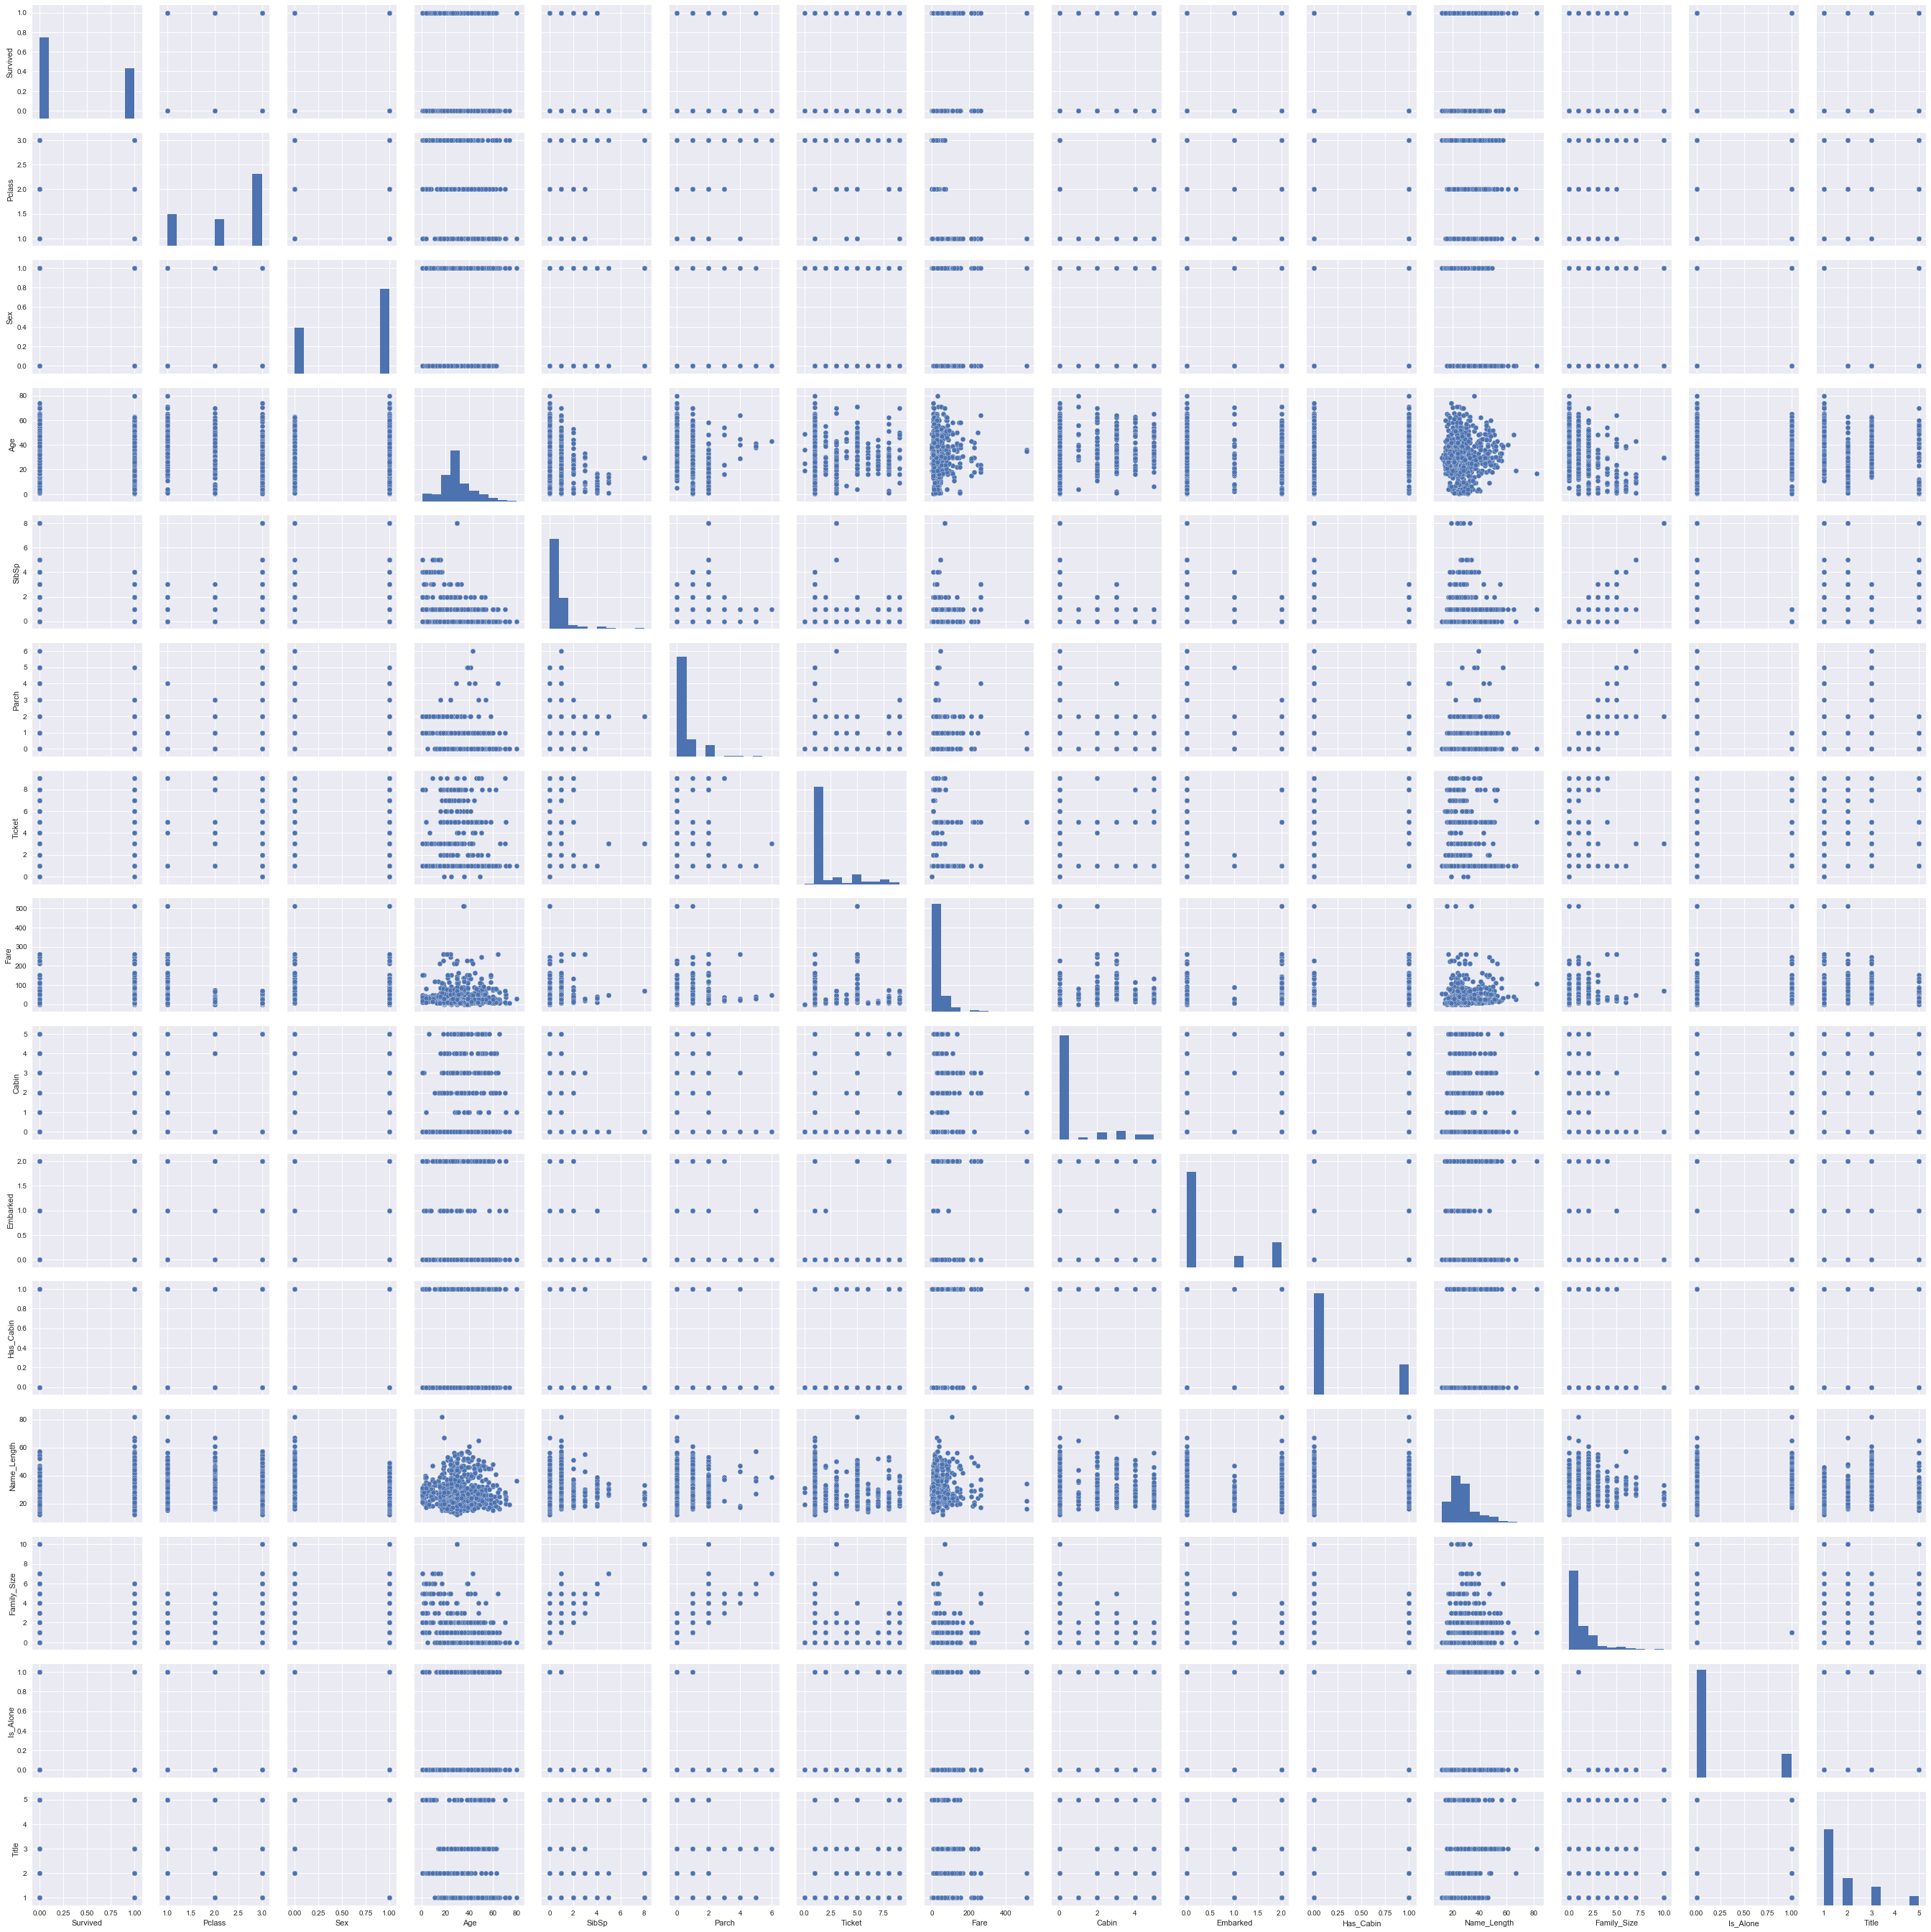

In [693]:
sns.pairplot(df_dropna)

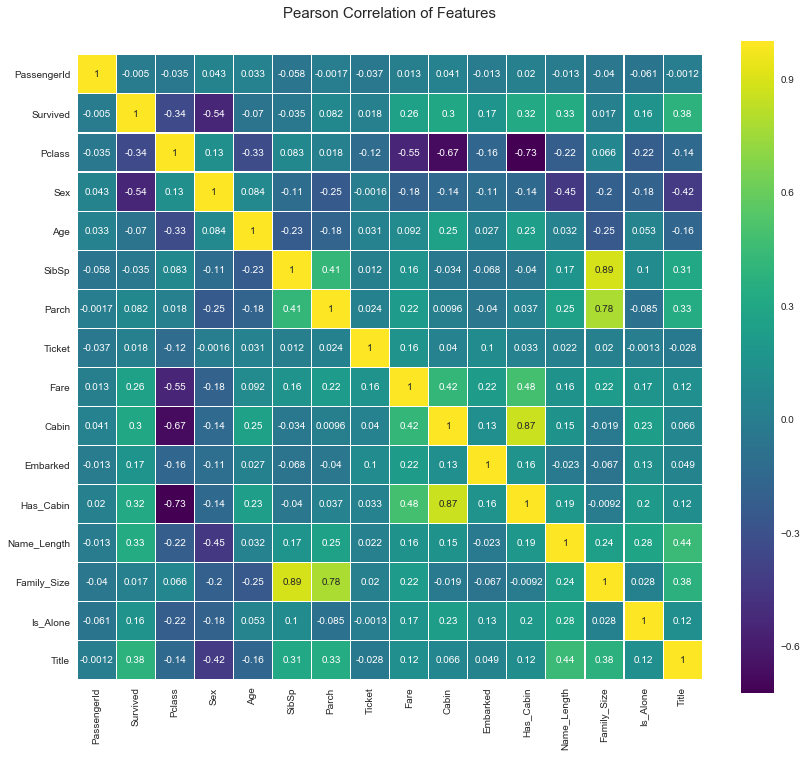

In [694]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

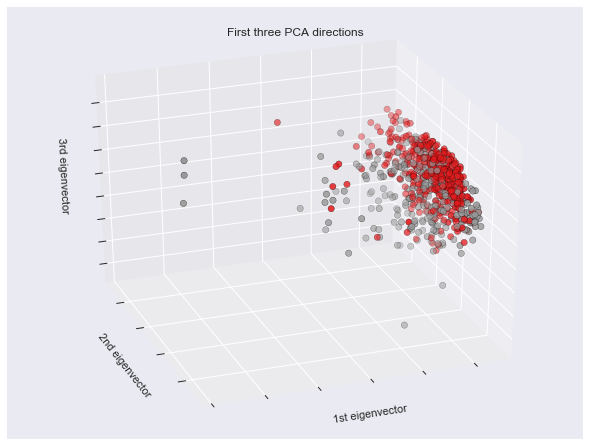

In [709]:
X = np.matrix(df.drop(['Survived','PassengerId'], axis=1))
Y = np.array(df['Survived'])

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

# Models

## SVM

In [954]:
# Input Data Preparation
X = np.matrix(df.drop(['Survived','PassengerId'], axis=1))
Y = np.array(df['Survived'])

print(X.shape)
print(Y.shape)
print(sum(Y)/len(Y))

(891, 14)
(891,)
0.383838383838


In [955]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=4242)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(712, 14)
(179, 14)
(712,)
(179,)


In [1027]:
from sklearn.svm import SVC
svm = SVC(C=1, kernel='linear')
svm.fit(x_train, y_train) 

y_pred = svm.predict(x_valid)
print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0], pd.Series(y_valid != y_pred).astype(int).sum()))
y_pred = svm.predict(x_train)
print("Number of mislabeled points out of a total %d points : %d" % (x_train.shape[0], pd.Series(y_train != y_pred).astype(int).sum()))

Number of mislabeled points out of a total 179 points : 36
Number of mislabeled points out of a total 891 points : 158


## XGBOOST

In [1058]:
# plot decision tree
from xgboost import XGBClassifier

# fit model no training data
xgb1 = XGBClassifier(learning_rate=0.4, n_estimators=200)
xgb1.fit(x_train, y_train)

y_pred = xgb1.predict(x_train)
print("Number of mislabeled points out of a total %d points : %d" % (x_train.shape[0],(y_train != y_pred).sum()))
y_pred = xgb1.predict(x_train)
print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0], pd.Series(y_valid != y_pred).astype(int).sum()))

Number of mislabeled points out of a total 891 points : 19
Number of mislabeled points out of a total 179 points : 1


## Cross-Validation

In [958]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
## learning rate: Lower values generalize well.
params['max_depth'] = 4
## control over-fitting, higher depth specific to a particular sample.

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-logloss:0.671941	valid-logloss:0.674363
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.525449	valid-logloss:0.550142
[20]	train-logloss:0.444994	valid-logloss:0.490016
[30]	train-logloss:0.39678	valid-logloss:0.458381
[40]	train-logloss:0.367083	valid-logloss:0.444757
[50]	train-logloss:0.34605	valid-logloss:0.438721
[60]	train-logloss:0.333329	valid-logloss:0.437572
[70]	train-logloss:0.321924	valid-logloss:0.437595
[80]	train-logloss:0.313314	valid-logloss:0.43892
[90]	train-logloss:0.305579	valid-logloss:0.440838
[100]	train-logloss:0.299696	valid-logloss:0.443208
[110]	train-logloss:0.29457	valid-logloss:0.444074
[120]	train-logloss:0.290426	valid-logloss:0.443811
[130]	train-logloss:0.286216	valid-logloss:0.443817
[140]	train-logloss:0.283151	valid-logloss:0.444811
[150]	train-logloss:0.279713	valid-logloss:0.445925
Stopping. Best iteration:
[57]	

In [959]:
y_pred = bst.predict(xgb.DMatrix(x_valid)) > 0.5
print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0],(y_valid != y_pred).sum()))

Number of mislabeled points out of a total 179 points : 36


# Prediction

In [1059]:
df_test = pd.read_csv('test.csv')
ID = df_test['PassengerId']
df_test = preprocess(df_test.drop('PassengerId', axis=1))

X_test = np.matrix(df_test)

# y_pred = bst.predict(xgb.DMatrix(X_test))
y_pred = xgb1.predict(X_test)
print(X_test.shape)
print(y_pred.shape)

(418, 14)
(418,)


In [1060]:
df_submit = pd.DataFrame()
df_submit['PassengerId'] = ID
df_submit['Survived'] = (y_pred > 0.5) * 1
# df_submit['Survived'] = 0
df_submit.to_csv("submit.csv", index=False)

# unsemble skill

In [200]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;


from xgboost import XGBClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [213]:
# Input Data Preparation
df = pd.read_csv('train.csv')
df = preprocess(df)
x_train = np.matrix(df.drop(['Survived','PassengerId'], axis=1))
y_train = np.array(df['Survived'])

df_test = pd.read_csv('test.csv')
ID = df_test['PassengerId']
x_test = np.matrix(preprocess(df_test.drop('PassengerId', axis=1)))

print(y_train.shape)
print(x_train.shape)
print(x_test.shape)

(891,)
(891, 16)
(418, 16)


In [214]:
# Some useful parameters which will come in handy later on
ntrain = df.shape[0]
ntest = df_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [215]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)  ## 這裡的test set應是指dev set
        oof_test_skf[i, :] = clf.predict(x_test)  ##真實的test set

    oof_test[:] = oof_test_skf.mean(axis=0)

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [216]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 1
    }

# XGB Classifier parameters 
xgb_params = {
    'learning_rate' : 0.4
    }

# Decision Tree parameters
dt_params = {
    "criterion":"entropy"
}

# Naïve Bayes
nb_params ={
    
}

# K nearest neighbor
knn_params = {
    "n_neighbors":5
}

In [217]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

# xgb = SklearnHelper(clf=XGBClassifier, seed=SEED, params=xgb_params)
# dt = SklearnHelper(clf=tree.DecisionTreeClassifier, seed=SEED, params=dt_params)
# nb = SklearnHelper(clf=GaussianNB, seed=SEED, params=nb_params)
# knn = SklearnHelper(clf=KNeighborsClassifier, seed=SEED, params=knn_params)

In [218]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier


# xgb_oof_train, xgb_oof_test = get_oof(xgb,x_train, y_train, x_test) # XGB Classifier
# dt_oof_train, dt_oof_test = get_oof(dt,x_train, y_train, x_test) # decision tree Classifier
# nb_oof_train, nb_oof_test = get_oof(nb,x_train, y_train, x_test) # Naïve Bayes Classifier
# knn_oof_train, knn_oof_test = get_oof(knn,x_train, y_train, x_test) # K nearest neighbor Classifier

print("Training is complete")

Training is complete


In [219]:
print("Training Set Number: {}".format(x_train.shape[0]))
print("- Random Forest: {}".format((y_train != rf_oof_train.reshape(y_train.shape)).sum()))
print("- Extra Trees: {}".format((y_train != et_oof_train.reshape(y_train.shape)).sum()))
print("- AdaBoost parameters: {}".format((y_train != ada_oof_train.reshape(y_train.shape)).sum()))
print("- Gradient Boosting : {}".format((y_train != gb_oof_train.reshape(y_train.shape)).sum()))
print("- SVM: {}".format((y_train != svc_oof_train.reshape(y_train.shape)).sum()))

# print("- XGBoost: {}".format((y_train != xgb_oof_train.reshape(y_train.shape)).sum()))
# print("- Decision tree: {}".format((y_train != dt_oof_train.reshape(y_train.shape)).sum()))
# print("- Naïve Bayes: {}".format((y_train != nb_oof_train.reshape(y_train.shape)).sum()))
# print("- K Nearest Neighbor: {}".format((y_train != knn_oof_train.reshape(y_train.shape)).sum()))



Training Set Number: 891
- Random Forest: 118
- Extra Trees: 155
- AdaBoost parameters: 175
- Gradient Boosting : 176
- SVM: 165


- Training Set Number: 891
- Random Forest: 118
- Extra Trees: 162
- AdaBoost parameters: 175
- Gradient Boosting : 170
- SVM: 167


Training Set Number: 891
- Random Forest: 114
- Extra Trees: 156
- AdaBoost parameters: 175
- Gradient Boosting : 168
- SVM: 167
- XGBoost: 155
- Decision tree: 226
- Naïve Bayes: 222
- K Nearest Neighbor: 252


Training Set Number: 891
- Random Forest: 113
- Extra Trees: 161
- AdaBoost parameters: 175
- Gradient Boosting : 171
- SVM: 167
- XGBoost: 155
- Decision tree: 209
- Naïve Bayes: 222
- K Nearest Neighbor: 252

# Prediction

In [220]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

# x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, xgb_oof_train, dt_oof_train, nb_oof_train, knn_oof_train), axis=1)
# x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, xgb_oof_test, dt_oof_test, nb_oof_test, knn_oof_test), axis=1)

# x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, x_train), axis=1)
# x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, x_test), axis=1)

In [221]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(712, 5)
(179, 5)
(712,)
(179,)


In [222]:
import xgboost

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
params['max_depth'] = 4
params['learning_rate'] = 0.04
params['gamma'] = 0.9
params['n_estimators'] = 2000

## control over-fitting, higher depth specific to a particular sample.
d_train = xgboost.DMatrix(x_train, label=y_train)
d_valid = xgboost.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 200, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-logloss:0.671323	valid-logloss:0.673684
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.523675	valid-logloss:0.544423
[20]	train-logloss:0.449932	valid-logloss:0.479711
[30]	train-logloss:0.411653	valid-logloss:0.446267
[40]	train-logloss:0.392011	valid-logloss:0.429307
[50]	train-logloss:0.381827	valid-logloss:0.421051
[60]	train-logloss:0.375877	valid-logloss:0.417549
[70]	train-logloss:0.372457	valid-logloss:0.416536
[80]	train-logloss:0.370517	valid-logloss:0.416468
[90]	train-logloss:0.369217	valid-logloss:0.4167
[100]	train-logloss:0.369189	valid-logloss:0.417105
[110]	train-logloss:0.369177	valid-logloss:0.417383
[120]	train-logloss:0.369171	valid-logloss:0.417571
[130]	train-logloss:0.369169	valid-logloss:0.417698
[140]	train-logloss:0.369168	valid-logloss:0.417784
[150]	train-logloss:0.369167	valid-logloss:0.417841
[160]	train-logloss:0.369167	

In [223]:
y_pred = bst.predict(xgboost.DMatrix(x_valid))
print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0],(y_valid != (y_pred > 0.5)).sum()))

Number of mislabeled points out of a total 179 points : 25


In [224]:
predictions = (bst.predict(xgboost.DMatrix(x_test)) > 0.5) * 1
# print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0],(y_valid != (y_pred > 0.5)).sum()))

In [225]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': ID,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [1125]:
gbm = XGBClassifier(
    learning_rate = 0.02,
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    #gamma=1,
    gamma=0.9,                        
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1,
    ).fit(x_train, y_train)
predictions = gbm.predict(x_test)

1. 0.66985: SVM + original feature => XGB
2. 0.73205: add feature(namelength  + title(ex. Miss) + cabin_binary) => SVM + original feature => XGB
3. 0.79425: same feature => (random forest + extra tree + Gradient Boosting + SVC) with cross-validate => XGB
4. 0.80382: same feature => (random forest + extra tree + Gradient Boosting + SVC) with cross-validate => XGB with cross-validate
5. 0.79904: same feature => (random forest + extra tree + Gradient Boosting + SVC + XGB + KNN + decision tree + Naïve Bayes) with cross-validate => XGB with cross-validate

# Features

In [1102]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

# xgb_feature = xgb.feature_importances(x_train,y_train)
# dt_feature = dt.feature_importances(x_train, y_train)
# nb_feature = nb.feature_importances(x_train, y_train)
# knn_feature = knn.feature_importances(x_train,y_train)

[ 0.07622326  0.22680504  0.06667652  0.02720097  0.01437319  0.01567866
  0.10025611  0.04764134  0.01782068  0.04037614  0.08626367  0.05043842
  0.00540786  0.22483814]
[ 0.10862991  0.37672569  0.02909005  0.02756788  0.01846151  0.01490371
  0.0328995   0.04618455  0.0266209   0.07173961  0.0443687   0.03470401
  0.01135868  0.15674528]
[ 0.022  0.012  0.202  0.006  0.032  0.056  0.422  0.022  0.014  0.     0.166
  0.036  0.004  0.006]
[ 0.02115794  0.01141339  0.26171752  0.01369427  0.00809073  0.04831936
  0.27004679  0.02018925  0.03231896  0.00344239  0.24238893  0.01824548
  0.01253143  0.03644355]
[ 0.02689076  0.03193277  0.2672269   0.02016807  0.00336134  0.04705882
  0.28739497  0.03529412  0.04201681  0.00336134  0.18991597  0.02016807
  0.00336134  0.02184874]
[ 0.04005105  0.01113658  0.16210701  0.00425184  0.0070799   0.01602553
  0.16975639  0.0453581   0.00886145  0.          0.12817084  0.08184391
  0.00492703  0.32043036]


In [993]:
rf_features = [0.08746069, 0.19729015, 0.06932047, 0.02640997, 0.01644295, 0.02024033, 0.11765421, 0.04830488, 0.01748685, 0.04384128, 0.07596576, 0.05033251, 0.00644041, 0.22280952]
et_features = [0.10272699, 0.36585049, 0.03025949, 0.02755789, 0.01889359, 0.01441089, 0.03323305, 0.04152479, 0.0268762, 0.07661973, 0.04387423, 0.03925289, 0.01167099, 0.16724877]
ada_features = [0.022, 0.012, 0.202, 0.006, 0.032, 0.056, 0.422, 0.022, 0.014, 0.0, 0.166, 0.036, 0.004, 0.006]
gb_features = [0.02102872, 0.01114695, 0.26176352, 0.01406133, 0.00806374, 0.04712413, 0.27005561, 0.01991496, 0.0323243, 0.00378681, 0.24430883, 0.01832264, 0.01200306, 0.03609539]


In [994]:
cols = df.drop(['Survived','PassengerId'], axis=1).columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [995]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [996]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.022,0.102727,0.021029,0.087461,Pclass,0.058304
1,0.012,0.365850,0.011147,0.197290,Sex,0.146572
2,0.202,0.030259,0.261764,0.069320,Age,0.140836


In [998]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [1000]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [1001]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')